#  量子神经网络

##  一 环境准备

请安装如下库：<br />
qutrunk 0.1.15 <br />
torch 1.13.0+cu116 <br />
torchvision 0.14.0 <br />
torchaudio 0.13.0

## 二 使用QuTrunk创建量子电路

In [1]:
import numpy as np
import json

from qutrunk.circuit import QCircuit
from qutrunk.circuit.gates import H, Ry, Measure, Barrier


class QuantumCircuit:

    def __init__(self, shots=100):
        self.shots = shots

    def _new_circuit(self, theta):
        # Create quantum circuit
        self._circuit = QCircuit()
        # Allocate quantum qubits
        qr = self._circuit.allocate(1)
        # apply gates
        H * qr[0]
        Barrier * qr
        Ry(theta) * qr[0]
        # measure
        Measure * qr[0]

    def run(self, theta):
        self._new_circuit(theta)

        result = self._circuit.run(shots=self.shots)
        result = result.get_counts()
        result = json.loads(result)

        counts = []
        states = []
        for r in result:
            for key, value in r.items():
                states.append(int(key, base=2))
                counts.append(value)

        states = np.array(states).astype(float)
        counts = np.array(counts)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)

        return np.array([expectation])


In [2]:
circuit = QuantumCircuit()
print(f'Expected value for rotation pi= {circuit.run(np.pi)[0]}')

Expected value for rotation pi= 0.55


## 三 加载训练数据集和测试数据集

In [3]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
# train dataset
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [5]:
# test dataset
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [6]:
def show_data():
    n_samples_show = 6

    data_iter = iter(train_loader)
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    while n_samples_show > 0:
        images, targets = data_iter.__next__()

        axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
        axes[n_samples_show - 1].set_xticks([])
        axes[n_samples_show - 1].set_yticks([])
        axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

        n_samples_show -= 1


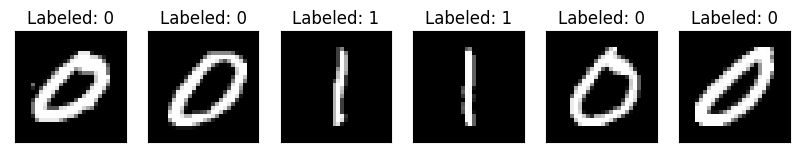

In [7]:
# show data
show_data()

## 四 混合量子-经典神经层

In [8]:
import numpy as np
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run(input[0].tolist()[0])
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i][0])
            expectation_left = ctx.quantum_circuit.run(shift_left[i][0])
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None


In [10]:
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit()
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(shift=np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

## 五 模型训练

In [13]:
import torch.optim as optim
import torch.nn as nn
from matplotlib import pyplot as plt

In [14]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())

    loss_list.append(sum(total_loss) / len(total_loss))
    print(
        "Training [{:.0f}%]\tLoss: {:.4f}".format(
            100.0 * (epoch + 1) / epochs, loss_list[-1]
        )
    )

C:\Users\wsh\AppData\Local\Temp\ipykernel_14036\1673489329.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  result = torch.tensor([expectation_z])
C:\Users\wsh\AppData\Local\Temp\ipykernel_14036\1673489329.py:30: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.7514
Training [10%]	Loss: -0.9026
Training [15%]	Loss: -0.9289
Training [20%]	Loss: -0.9387
Training [25%]	Loss: -0.9458
Training [30%]	Loss: -0.9562
Training [35%]	Loss: -0.9567
Training [40%]	Loss: -0.9567
Training [45%]	Loss: -0.9688
Training [50%]	Loss: -0.9701
Training [55%]	Loss: -0.9688
Training [60%]	Loss: -0.9773
Training [65%]	Loss: -0.9816
Training [70%]	Loss: -0.9865
Training [75%]	Loss: -0.9862
Training [80%]	Loss: -0.9861
Training [85%]	Loss: -0.9875
Training [90%]	Loss: -0.9862
Training [95%]	Loss: -0.9890
Training [100%]	Loss: -0.9875


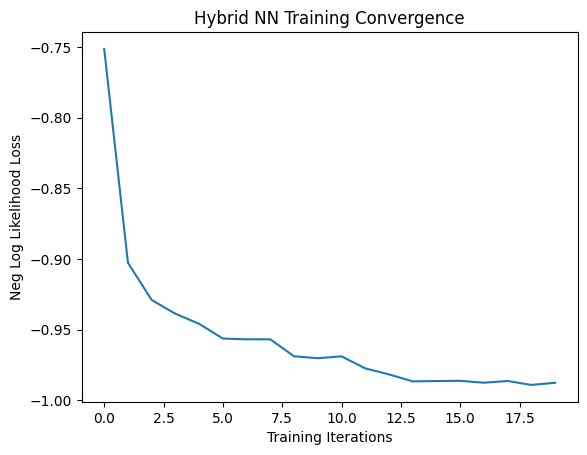

In [15]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg Log Likelihood Loss")
plt.show()

## 六 模型评估

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print(f'Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {correct / len(test_loader) * 100:.1f}%')

In [ ]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title(f'Predicted {pred.item()}')
        
        count += 1